In [1]:
import cv2
import math  
import numpy as np
import random as r
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

# Node
This class represents a model of a single node in the som map, which contains an x and y position, as well as a weight vector and assigned data vectors. Weight vectors are used to assign data vectors to nodes further down in the code.

In [ ]:
class Node:
    x = 0
    y = 0
    weights = []
    vectors = []
    
    def __init__(self, x, y, weights):
        self.x = x
        self.y = y        
        self.weights = weights 
        self.vectors = []
    '''
    def getX(): 
        return x
    
    def getY(): 
        return y
    
    def getWeights(): 
        return weights
    
    def setWeights(weights): 
        self.weights = weights
    '''
        
    ''' Function calculates weight distance between this node and any given vector'''
    def getDistance(self, vector):
        distance = 0
        for i in range(len(self.weights)):
            distance += (vector[i] - self.weights[i]) * (vector[i] - self.weights[i])
        return math.sqrt(distance)
    
    ''' Function calculates weight distance between this node and another node'''
    def getNodeDistance(self, node):
        distance = 0
        for i in range(len(self.weights)):
            distance += (node.weights[i] - self.weights[i]) * (node.weights[i] - self.weights[i])
        return math.sqrt(distance)
    
    ''' Function calculates positional distance between this node and another node'''
    def getPhysicalDistance(self, node):
        dX = (self.x-node.x)
        dY = (self.y-node.y)
        return math.sqrt(dX*dX + dY*dY)
    
    ''' Function adds a vector to the vectors list'''
    def addVector(self, vector):
        self.vectors.append(vector)

# SOM
This class represents the 2D Self-Organizing Map, which includes x and y attributes for the map sizing, sigma, learning rate, and width attributes, used to implement the actual clustering.

In [76]:
class SOM:
    somMap = []
    magnitudes = []
    x = 10
    y = 10
    width = 10
    s = 1.0 # Sigma
    a = 0.5 # Learning Rate
    
    def __init__(self, x=10, y=10, s=1.0, a=0.5):
        self.x = x
        self.y = y
        self.s = s
        self.a = a
        self.width = max(x, y)
        
        print(self.width)
        print(math.log(self.width))
        
        # Initialize Map
        for i in range(self.x):
            self.somMap.append([Node(i, j, self.getRandomWeightVector()) for j in range(self.y)])
    
    def getRandomWeightVector(self, length=1):
        return [r.uniform(0, 1) for i in range(length)]
    
    def initializeWeights(self, length):
        for i in range(self.x):
            for j in range(self.y):
                self.somMap[i][j].weights = self.getRandomWeightVector(length)
                
    def findBMU(self, vector):
        bmu = self.somMap[0][0]
        minDist = None

        for nodes in self.somMap:
            for node in nodes:
                distance = node.getDistance(vector)

                if (minDist == None):
                    minDist = distance
                    bmu = node
                elif (distance < minDist):
                    # Current shortest distance
                    minDist = distance
                    bmu = node
        return bmu
    
    def decayRadius(self, i, epoch):
        lamb = epoch/math.log(self.width)
        return self.width*math.exp(-i/lamb)
    
    def decayLearningRate(self, i, epoch, rate):
        return rate*math.exp(-i/epoch)
    
    def calculateInfluence(self, dist):
        return math.exp(-(dist * dist)/(2 * self.width * self.width))
    
    def updateNeighbourhood(self, vector, bmu, radius, a):
        # Calculate neighbourhood
        for nodes in self.somMap:
            for node in nodes:
                w = []
                dist = bmu.getPhysicalDistance(node)
                if (dist <= radius):
                    # Calculate new weight: w' = w + o*l*(v-w)
                    a = self.calculateInfluence(dist) * a
                    for i in range(len(vector)):
                        w.append(bmu.weights[i] + a*(vector[i] - bmu.weights[i]))
                    node.weights = w
    
    def train(self, data, epochs, epochSize=None):
        self.initializeWeights(len(data[0]))
        
        if epochSize == None:
            epochSize = len(data)
        
        for i in range(epochs):
            ts = np.arange(0, len(data))
            for j in range(epochSize):
                if  len(ts) <= 0:
                    break
                    
                tsIndex = r.randint(0, len(ts)-1)
                index = ts[tsIndex]
                np.delete(ts, tsIndex)

                # Select random input vector
                vector = data[index]

                # Find winning node
                bmu = self.findBMU(vector)

                # Decay Radius and Learning rate
                radius = self.decayRadius(0, epochs)
                self.a = self.decayLearningRate(0, 20, self.a)

                # Update winning node's neighbours
                self.updateNeighbourhood(vector, bmu, radius, self.a)
            
    def mapData(self, data):
        # Map data vectors to their winning node
        for i in range(len(data)):
            bmu = self.findBMU(data[i])
            self.somMap[bmu.x][bmu.y].addVector(data[i])
            
    def getDistanceMap(self):
        distMap = []
        distance = 0

        # Calculate node distance
        for i in range(self.x):
            distY = []
            for j in range(self.y):    
                if(self.somMap[(i-1)][j].weights != None):
                    t = self.somMap[(i-1)][j]
                    d = self.somMap[i][j].getNodeDistance(t)
                    distance += math.pow(d, 2)
                    
                if(i < (len(self.somMap)-1) and self.somMap[(i+1)][j].weights != None):
                    t = self.somMap[(i+1)][j]
                    d = self.somMap[i][j].getNodeDistance(t)
                    distance += math.pow(d, 2) 
                    
                if(self.somMap[i][(j-1)].weights != None):
                    t = self.somMap[i][(j-1)]
                    d = self.somMap[i][j].getNodeDistance(t)
                    distance += math.pow(d, 2)
                    
                if(j < (len(self.somMap[i])-1) and self.somMap[i][(j+1)].weights != None):
                    t = self.somMap[i][(j+1)]
                    d = self.somMap[i][j].getNodeDistance(t)
                    distance += math.pow(d, 2)
                
                distY.append(math.sqrt(distance))
            distMap.append(distY)
            distance = 0
        
        # Get max distance
        maxList = []
        for nodes in distMap:
            maxList.append(max(nodes))
        maxDist = max(maxList)
        
        # Normalize distance
        for i in range(self.x):
            for j in range(self.y):     
                distMap[i][j] /= maxDist
        return distMap
    
    def getOutliers(self, signal, distMap, somMap):
        # Find nodes with distance greater than signal
        outliers = []
        for i in range(len(distMap)):
            for j in range(len(distMap[i])):
                if(((distMap[i][j]) >= signal) and len(somMap[i][j].vectors) >= 1):
                    outliers.append(somMap[i][j])
        return outliers
    
    def printMap(self):
        for i in range(self.x):
            for j in range(self.y):    
                print("X:" + str(self.somMap[i][j].x) + "  Y:" + str(self.somMap[i][j].y) + "  w:" + str(self.somMap[i][j].weights) + "  v:" + str(self.somMap[i][j].vectors))
            print()

In [77]:
data = cv2.imread("4.jpg")
print(data.shape)
data = data.reshape(5134756, 3)
print(data.shape)

(2266, 2266, 3)
(5134756, 3)


In [78]:
# Normalize Data
norm = data / np.linalg.norm(data)

'''
print("Normalized:")
print(norm)
print()
print("Denormalized:")
print(norm * np.linalg.norm(data))
'''
som = SOM(10, 10, 1.0, 0.2)

10
2.302585092994046


Training!
Mapping Data!
Plotting Distance Map


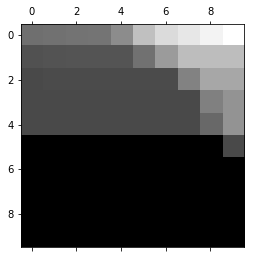

In [79]:
print("Training!")
som.train(norm, 2, 10000)
print("Mapping Data!")
som.mapData(norm[:100])
print("Plotting Distance Map")
dm = som.getDistanceMap()
plt.matshow(dm, cmap = plt.cm.gray)
plt.show()

Mapping Data!
Plotting Distance Map


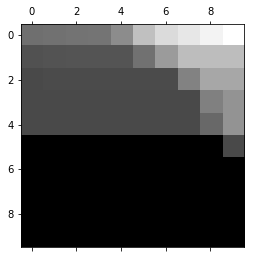

In [82]:
print("Mapping Data!")
som.mapData(norm[:1000])
print("Plotting Distance Map")
dm = som.getDistanceMap()
plt.matshow(dm, cmap = plt.cm.gray)
plt.show()

In [83]:
vecMap = [np.array(node.vectors)*np.linalg.norm(data) for nodes in som.somMap for node in nodes]
print(vecMap)

[array([[110., 110., 110.],
       [ 21.,  21.,  21.],
       [ 36.,  36.,  36.],
       [ 74.,  74.,  74.],
       [112., 112., 112.],
       [107., 107., 107.],
       [ 64.,  64.,  64.],
       [110., 110., 110.],
       [128., 128., 128.],
       [131., 131., 131.],
       [113., 113., 113.],
       [ 62.,  62.,  62.],
       [ 52.,  52.,  52.],
       [ 65.,  65.,  65.],
       [ 61.,  61.,  61.],
       [ 45.,  45.,  45.],
       [ 22.,  22.,  22.],
       [  8.,   8.,   8.],
       [ 10.,  10.,  10.],
       [ 25.,  25.,  25.],
       [ 46.,  46.,  46.],
       [ 49.,  49.,  49.],
       [ 56.,  56.,  56.],
       [ 60.,  60.,  60.],
       [ 67.,  67.,  67.],
       [ 69.,  69.,  69.],
       [ 46.,  46.,  46.],
       [ 25.,  25.,  25.],
       [ 25.,  25.,  25.],
       [ 56.,  56.,  56.],
       [ 71.,  71.,  71.],
       [ 75.,  75.,  75.],
       [ 84.,  84.,  84.],
       [ 95.,  95.,  95.],
       [105., 105., 105.],
       [124., 124., 124.],
       [ 64.,  64.,  64.],


In [80]:
outNodes = som.getOutliers(0.8, dm, som.somMap)
np.set_printoptions(suppress=True)
print(len(outNodes))

[np.array(x.vectors)*np.linalg.norm(data) for x in outNodes]

2


[array([[166., 166., 166.],
        [170., 170., 170.],
        [163., 163., 163.],
        [165., 165., 165.]]), array([[194., 194., 194.],
        [178., 178., 178.],
        [177., 177., 177.],
        [184., 184., 184.],
        [186., 186., 186.],
        [179., 179., 179.],
        [232., 232., 232.],
        [179., 179., 179.],
        [202., 202., 202.],
        [182., 182., 182.],
        [195., 195., 195.],
        [174., 174., 174.],
        [185., 185., 185.],
        [193., 193., 193.],
        [181., 181., 181.],
        [174., 174., 174.],
        [173., 173., 173.],
        [176., 176., 176.],
        [178., 178., 178.],
        [190., 190., 190.],
        [197., 197., 197.],
        [198., 198., 198.],
        [203., 203., 203.],
        [206., 206., 206.],
        [202., 202., 202.],
        [197., 197., 197.],
        [199., 199., 199.],
        [202., 202., 202.],
        [201., 201., 201.],
        [199., 199., 199.]])]

In [ ]:
x = np.arange(10)
y = np.arange(10)

print(x)

plt.scatter(x = x, y = y, s = dm)
plt.xlabel('entry a')
plt.ylabel('entry b')
plt.show()

In [ ]:
data = {'a': np.arange(50),
        'c': np.random.randint(0, 50, 50),
        'd': np.random.randn(50)}
data['b'] = data['a'] + 10 * np.random.randn(50)
data['d'] = np.abs(data['d']) * 100

plt.scatter('a', 'b', c='c', data=data)
plt.xlabel('entry a')
plt.ylabel('entry b')
plt.show()